<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejercicio basado en un ejemplo de la clase de la materia Procesamiento Natural del lenguaje, que a su vez esta basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

**Alumno:**

**Nahuel Otonelo Canale**

__________

### Datos
El objetivo es utilizar datos disponibles del Tatoeba Project de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor de inglés a español seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [3]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model

In [4]:
import sys
import tensorflow as tf

# 1. Verificar el Sistema Operativo y la Ruta de Python
# Si estás conectado al Kernel de ubuntu, 'sys.platform' debe ser 'linux'
print("-" * 50)
print(f"1. Sistema Operativo del Kernel: {sys.platform}") 
print(f"2. Ruta del ejecutable de Python: {sys.executable}")
print("-" * 50)

# 2. Verificar la disponibilidad de GPU (TensorFlow)
# Esto confirmará si el kernel (motor) que seleccionaste tiene acceso a tu GPU
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✅ ¡ÉXITO! TensorFlow detectó {len(gpus)} GPU(s).")
        for gpu in gpus:
            print(f"   - Dispositivo: {gpu.name}")
    else:
        print("❌ TensorFlow NO detectó la GPU. Se está usando la CPU.")
except Exception as e:
    print(f"⚠️ Error al verificar TensorFlow: {e}. Asegúrate de que la librería esté instalada en el Kernel seleccionado.")

--------------------------------------------------
1. Sistema Operativo del Kernel: linux
2. Ruta del ejecutable de Python: /home/nahuel/miniconda3/bin/python3.13
--------------------------------------------------
✅ ¡ÉXITO! TensorFlow detectó 1 GPU(s).
   - Dispositivo: /physical_device:GPU:0


In [5]:
# Descargar la carpeta de dataset

import os
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip 
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [6]:
#input_sentences[0], output_sentences[0], output_sentences_inputs[0]

### 2 - Preprocesamiento

¿Cuál es el tamaño del vocabulario?

In [7]:
# 1. Leer todo el archivo (sin límite de 6000) como en el ejemplo de la clase
text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
print(f"Total de oraciones disponibles: {len(lines)}")
# 2. Separar todos los textos
all_eng = []
all_spa = []
for line in lines:
    if '\t' not in line: continue
    eng, spa = line.rstrip().split('\t')
    all_eng.append(eng)
    all_spa.append(spa)
# 3. Contar palabras únicas usando Tokenizer (sin filtro num_words)
from tensorflow.keras.preprocessing.text import Tokenizer
# Inglés
tokenizer_eng_full = Tokenizer()
tokenizer_eng_full.fit_on_texts(all_eng)
print(f"Vocabulario Único Inglés: {len(tokenizer_eng_full.word_index)}")
# Español
tokenizer_spa_full = Tokenizer()
tokenizer_spa_full.fit_on_texts(all_spa)
print(f"Vocabulario Único Español: {len(tokenizer_spa_full.word_index)}")

Total de oraciones disponibles: 118964
Vocabulario Único Inglés: 13524
Vocabulario Único Español: 26934


In [8]:

import numpy as np
# 1. Configuración del Dataset
# ORIGINAL: 6000
# RECOMENDADO: 30000 - 120000 (Si pones None lee TODO el archivo)
MAX_NUM_SENTENCES = 30000
# 2. Leer archivo
text_file = "./spa-eng/spa.txt"
with open(text_file) as f:
    # Leemos TODAS las líneas primero
    lines = f.read().split("\n")[:-1]
# 3. Mezclar (Shuffle) con semilla fija para reproducibilidad
np.random.seed(40)
np.random.shuffle(lines)
# 4. Limitar cantidad (si aplica)
if MAX_NUM_SENTENCES is not None:
    lines = lines[:MAX_NUM_SENTENCES]
print(f"Total de oraciones seleccionadas para entrenar: {len(lines)}")
# 5. Procesar líneas y separar idiomas
input_sentences = []        # Inglés
output_sentences = []       # Español (Target con <eos>)
output_sentences_inputs = [] # Español (Input al decoder con <sos>)
for line in lines:
    if '\t' not in line: 
        continue
    # Input sentence --> eng (Inglés)
    # output --> spa (Español)
    input_sentence, output = line.rstrip().split('\t')
    # output sentence (decoder_output) tiene <eos> al final
    # Ejemplo: "hola <eos>"
    output_sentence = output + ' <eos>'
    
    # output sentence input (decoder_input) tiene <sos> al principio
    # Ejemplo: "<sos> hola"
    output_sentence_input = '<sos> ' + output
    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)
print(f"Listas de oraciones creadas. Ejemplo 0:")
print(f"IN (Eng): {input_sentences[0]}")
print(f"OUT (Spa): {output_sentences[0]}")

Total de oraciones seleccionadas para entrenar: 30000
Listas de oraciones creadas. Ejemplo 0:
IN (Eng): Somebody stole my car.
OUT (Spa): Alguien robó mi auto. <eos>


In [9]:
# --- CÁLCULO DINÁMICO DE VOCABULARIO (80% DEL TOTAL) ---
# Para no poner un numero fijo, tomamos el 80% del vocabulario de cada idioma

# 1. Unir todos los textos cargados para análisis
all_eng_texts = input_sentences
# Quitamos <sos> y <eos> para contar el vocabulario real de español
all_spa_texts = [s.replace('<sos> ', '').replace(' <eos>', '') for s in output_sentences]

# 2. Análisis preliminar para contar totales
from tensorflow.keras.preprocessing.text import Tokenizer as TokenizerAnalysis

# Inglés
tok_eng_analisis = TokenizerAnalysis()
tok_eng_analisis.fit_on_texts(all_eng_texts)
total_vocab_eng = len(tok_eng_analisis.word_index)

# Español 
tok_spa_analisis = TokenizerAnalysis(filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
tok_spa_analisis.fit_on_texts(all_spa_texts)
total_vocab_spa = len(tok_spa_analisis.word_index)

print(f"Vocabulario Encontrado (en las {MAX_NUM_SENTENCES} oraciones) - Inglés: {total_vocab_eng} | Español: {total_vocab_spa}")

# 3. Definir límites al porcentaje del total del vocabulario
porcentaje = 0.8
MAX_VOCAB_SIZE_ENG = int(total_vocab_eng * porcentaje)
MAX_VOCAB_SIZE_SPA = int(total_vocab_spa * porcentaje)

print(f"Límite establecido (80%) - Inglés: {MAX_VOCAB_SIZE_ENG} | Español: {MAX_VOCAB_SIZE_SPA}")

Vocabulario Encontrado (en las 30000 oraciones) - Inglés: 8072 | Español: 13952
Límite establecido (80%) - Inglés: 6457 | Español: 11161


In [10]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from tensorflow.keras.preprocessing.text import Tokenizer
# tokenizador de inglés
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE_ENG) 
input_tokenizer.fit_on_texts(input_sentences)


input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 8072
Sentencia de entrada más larga: 34


In [11]:
# tokenizador de español
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE_SPA, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens

output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE_SPA) 
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 13954
Sentencia de salida más larga: 43


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario, por eso decidí limitar al vocabulario a un porcentaje del total.

In [12]:
# RESTRICCIÓN DE LARGO DE SECUENCIA
# ORIGINAL: Se limitaba a 16 y 18 para ahorrar RAM.
# DESAFÍO: Comentamos estas líneas para usar el largo TOTAL real de las oraciones.
# (Las variables max_input_len y max_out_len ya fueron calculadas con el valor real en las celdas anteriores)
# max_input_len = 16  <-- COMENTADO
# max_out_len = 18    <-- COMENTADO
print(f"Usando largo máximo real -> Entrada: {max_input_len} | Salida: {max_out_len}")

Usando largo máximo real -> Entrada: 34 | Salida: 43


A la hora de realizar padding es importante tener en cuenta que en el encoder los ceros se agregan al comienzo y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [13]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 30000
encoder_input_sequences shape: (30000, 34)
decoder_input_sequences shape: (30000, 43)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategia con que se transformó la entrada del decoder.

In [14]:
# Mantenemos el padding 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
# Calculamos la secuencia con padding 
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
# --- CAMBIO IMPORTANTE ---
# En lugar de to_categorical, usamos solo expand_dims
# para agregar una dimensión extra -> (N, T, 1)
decoder_targets = np.expand_dims(decoder_output_sequences, -1)
print("decoder_targets shape (Sparse):", decoder_targets.shape)

decoder_targets shape (Sparse): (30000, 43, 1)


### 3 - Preparar los embeddings

In [15]:
# Descargar los embeddings desde un google drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque de código
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [16]:
# En caso de que gdown de algún error de permisos intentar descargar los
# embeddings con curl:

#!curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

In [17]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [18]:
# SELECCION DE EMBEDDINGS PRE-ENTRENADOS
# Opciones disponibles en la clase anterior:
# - GloveEmbeddings (50 dimensiones) -> Rápido, es el que voy a usar teniendo en cuenta la diponibilidad de recursos
# - FasttextEmbeddings (300 dimensiones) -> Más preciso, requiere más RAM
# Mantenemos Glove 50d por eficiencia computacional,
# pero la arquitectura soportaría FastText simplemente cambiando esta línea.
model_embeddings = GloveEmbeddings()
print(f"Embedding seleccionado: {type(model_embeddings).__name__}")
print(f"Dimensiones (N_FEATURES): {model_embeddings.N_FEATURES}")

Embedding seleccionado: GloveEmbeddings
Dimensiones (N_FEATURES): 50


In [19]:
# Crear la Embedding matrix de las secuencias
# en inglés

print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE_ENG, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 74


In [20]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(6457, 50)

### 4 - Entrenar el modelo

In [21]:
max_input_len

34

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, LSTM, Dense
from tensorflow.keras.models import Model
# --- ARQUITECTURA MEJORADA (Con Dropout y Definition de Embedding) ---
n_units = 256 # Confirmamos 256
# 1. Definición de la Capa de Embedding (Pre-entrenada)
# Esto faltaba:
encoder_embedding_layer = Embedding(
          input_dim=nb_words,            # Tamaño vocabulario real
          output_dim=embed_dim,          # 50 dim (GloVe)
          input_length=max_input_len,    # Largo secuencia entrada
          weights=[embedding_matrix],    # Pesos cargados de GloVe
          trainable=False                # No re-entrenar GloVe
)
# 2. ENCODER
encoder_inputs = Input(shape=(max_input_len,))
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)
# Agregamos DROPOUT al LSTM
encoder_lstm = LSTM(n_units, return_state=True, dropout=0.2) 
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs_x)
encoder_states = [state_h, state_c]
# 3. DECODER
decoder_inputs = Input(shape=(max_out_len,))
# Embedding del Decoder (Este se entrena desde cero)
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)
# LSTM del Decoder con Dropout
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
# 4. SALIDA
# Dense sin Softmax (Logits)
decoder_dense = Dense(num_words_output) 
decoder_outputs = decoder_dense(decoder_outputs)
# 5. MODELO FINAL
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# Compilación
opt = Adam(learning_rate=0.0005) 
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer=opt, 
              metrics=['accuracy'])
model.summary()

/home/nahuel/miniconda3/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1765508778.600856     428 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 43)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 50)    │    322,850 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 43, 256)   │  2,857,216 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    314,368 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 43, 256), │    525,312 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 43, 11161) │  2,868,377 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,888,123 (26.28 MB)

 Trainable params: 6,565,273 (25.04 MB)

 Non-trainable params: 322,850 (1.23 MB)

## FIT

In [26]:
# Esto entrena y guarda el modelo entrenado en disco. 
# La logica es no tener que entrenar para guardar en memoria.
# El código primero se fija si existe el modelo, si existe, lo carga y salta el entrenamiento.
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Nombre del archivo donde guardaremos (o buscaremos) los pesos
checkpoint_path = "translator_model_best.weights.h5"
# --- LÓGICA DE SEGURIDAD PARA NO RE-ENTRENAR AL PEPE ---
if os.path.exists(checkpoint_path):
    print(f"¡Encontrado modelo guardado en '{checkpoint_path}'! Cargando pesos y SALTANDO entrenamiento...")
    
    # Carga los pesos en la estructura 'model' que definimos arriba
    model.load_weights(checkpoint_path)
    
    print("Modelo cargado exitosamente. Listo para usar.")
    history = None # No hay historial si no entrenamos, para que no falle graficar despues
else:
    print(f"No se encontró '{checkpoint_path}'. Iniciando entrenamiento...")
    
    callbacks = [
        # 1. Parar si no mejora la validation_loss en 3 épocas (Paciencia)
        EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
        
        # 2. Guardar solo el MEJOR modelo en el archivo checkpoint_path
        ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
    ]
    # Entrenamiento
    history = model.fit(
        # Entradas: [Encoder, Decoder]
        [encoder_input_sequences, decoder_input_sequences], 
        
        # Salida esperada (Target One-Hot)
        decoder_targets, 
        
        batch_size=32,        
        epochs=30,             
        validation_split=0.2,  
        callbacks=callbacks
    )

    print("Entrenamiento finalizado y mejores pesos guardados.")

No se encontró 'translator_model_best.weights.h5'. Iniciando entrenamiento...
Epoch 1/30


2025-12-12 00:06:54.597065: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8416 - loss: 1.9909
Epoch 1: val_loss improved from None to 0.88926, saving model to translator_model_best.weights.h5
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 38ms/step - accuracy: 0.8578 - loss: 1.2041 - val_accuracy: 0.8699 - val_loss: 0.8893
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8665 - loss: 0.9154
Epoch 2: val_loss improved from 0.88926 to 0.83816, saving model to translator_model_best.weights.h5
750/750 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - accuracy: 0.8673 - loss: 0.9039 - val_accuracy: 0.8738 - val_loss: 0.8382
Epoch 3/30
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8720 - loss: 0.8476
Epoch 3: val_loss improved from 0.83816 to 0.78229, saving model to translator_model_best.weights.h5
750/750 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.8726 - loss: 0.8393 - val_accuracy: 0.8793 - val_loss: 0.7823
Epoch 4/30
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8778 - loss: 0.7846
Epoch 

In [ ]:
# esto es para borrar el modelo por si se quiere cambiar algun parametro o reentrenar.
'''
import os
# 1. Directorio actual
print(f"Buscando en: {os.getcwd()}")
# 2. Archivo a eliminar
target_file = "translator_model_best.weights.h5"  # <--- Asegúrate que coincida con el checkpoint_path
if os.path.exists(target_file):
    os.remove(target_file)
    print(f"✅ ¡Eliminado! Se borró: {target_file}")
    print("Ahora puedes correr la celda de entrenamiento y empezará de cero.")
else:
    print(f"❌ No encontré el archivo '{target_file}' en esta carpeta.")
    print("Si la celda de entrenamiento se salta, revisa si el nombre 'checkpoint_path' coincide.")
'''

Buscando en: /home/nahuel
✅ ¡Eliminado! Se borró: translator_model_best.weights.h5
Ahora puedes correr la celda de entrenamiento y empezará de cero.


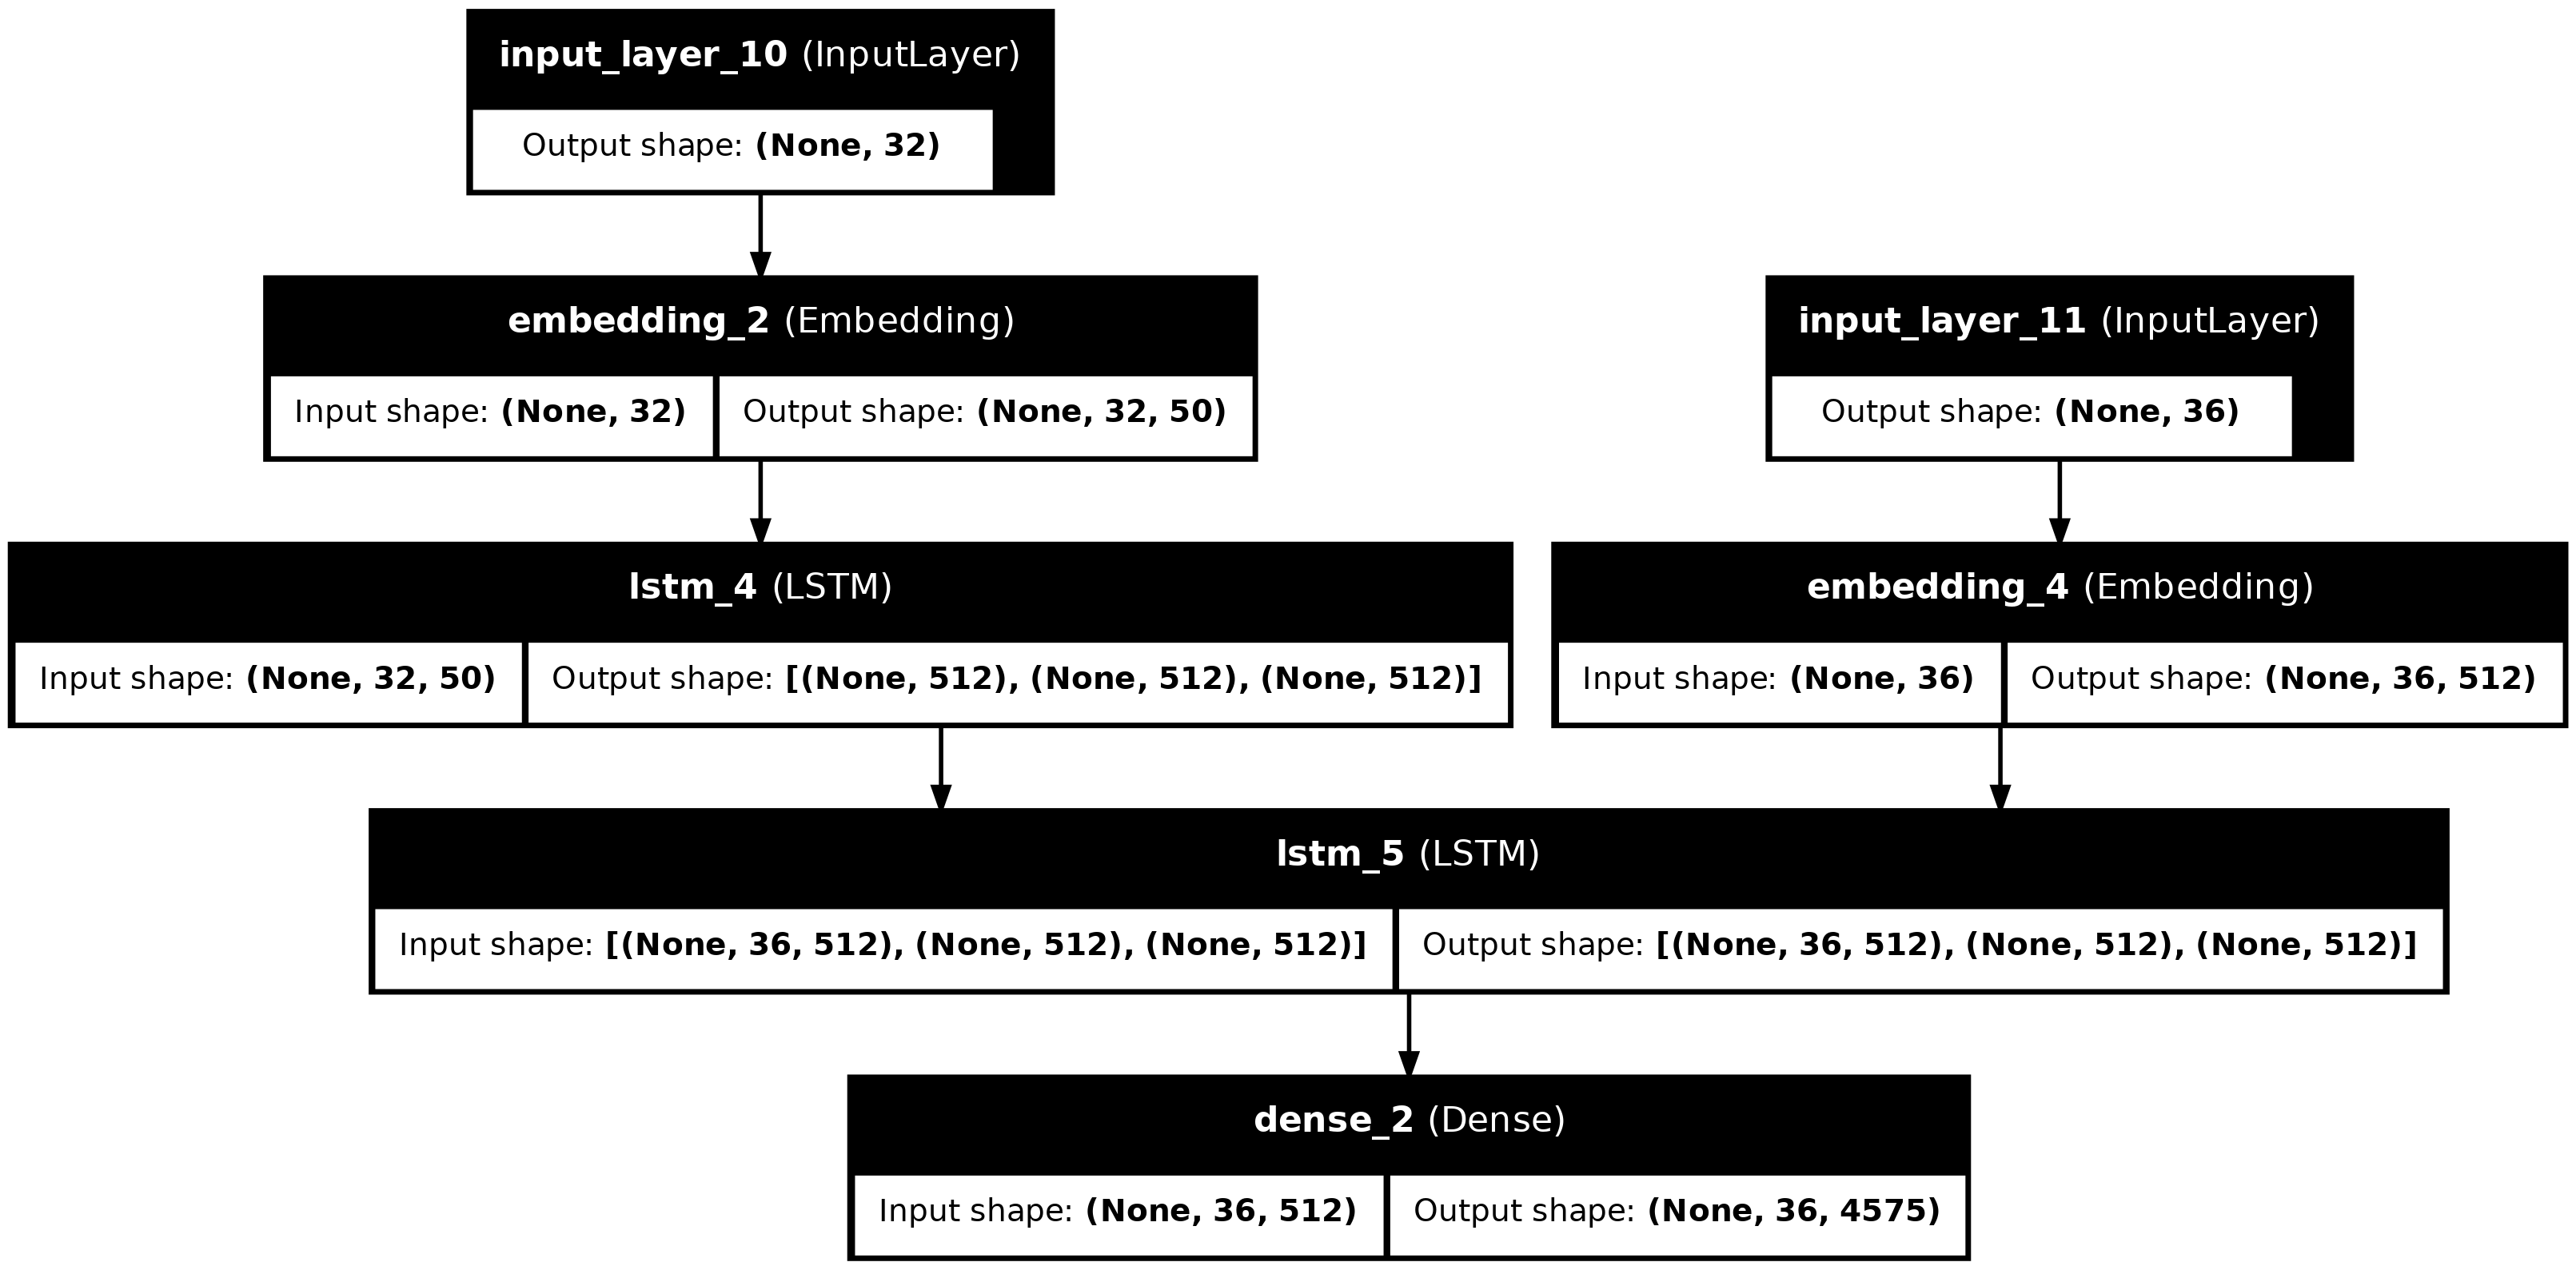

In [ ]:
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

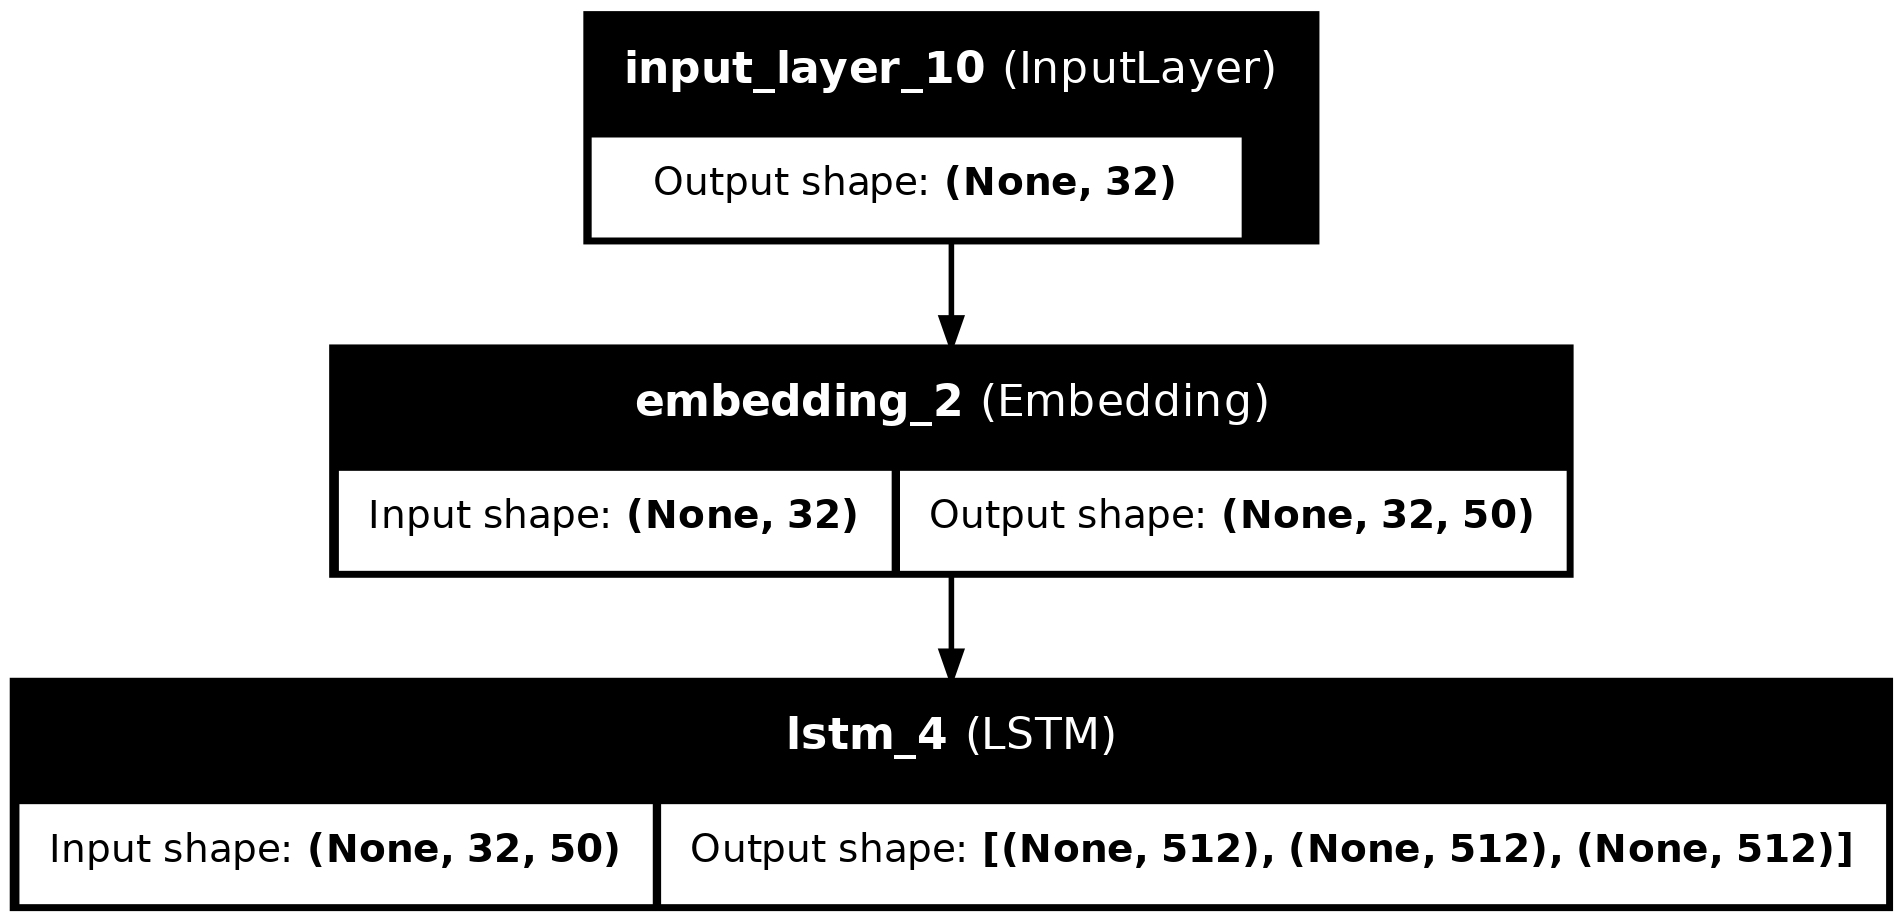

In [ ]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

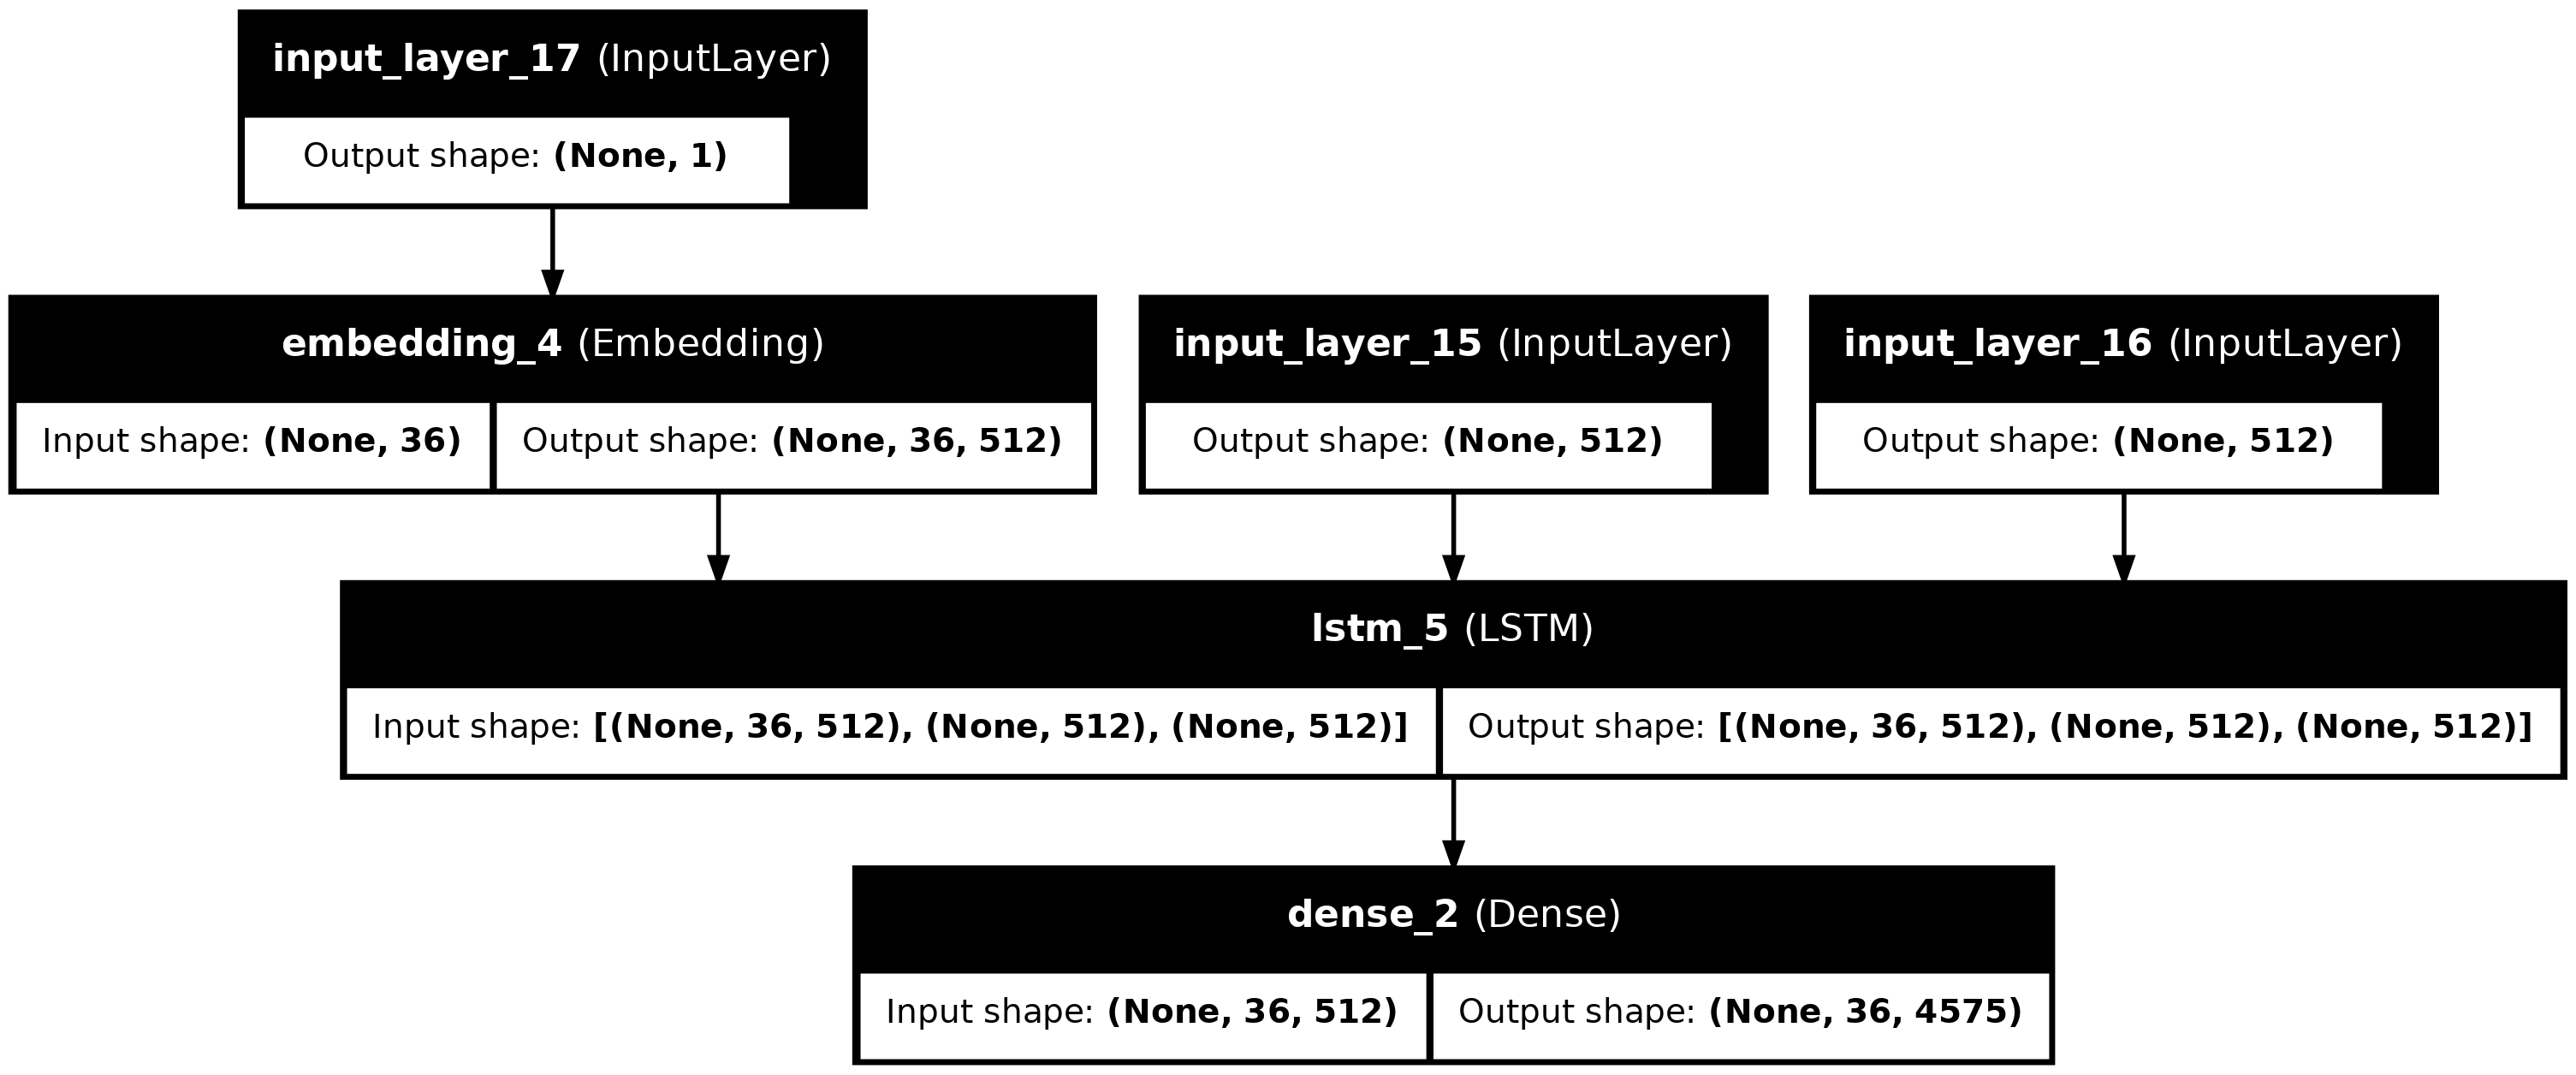

In [ ]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

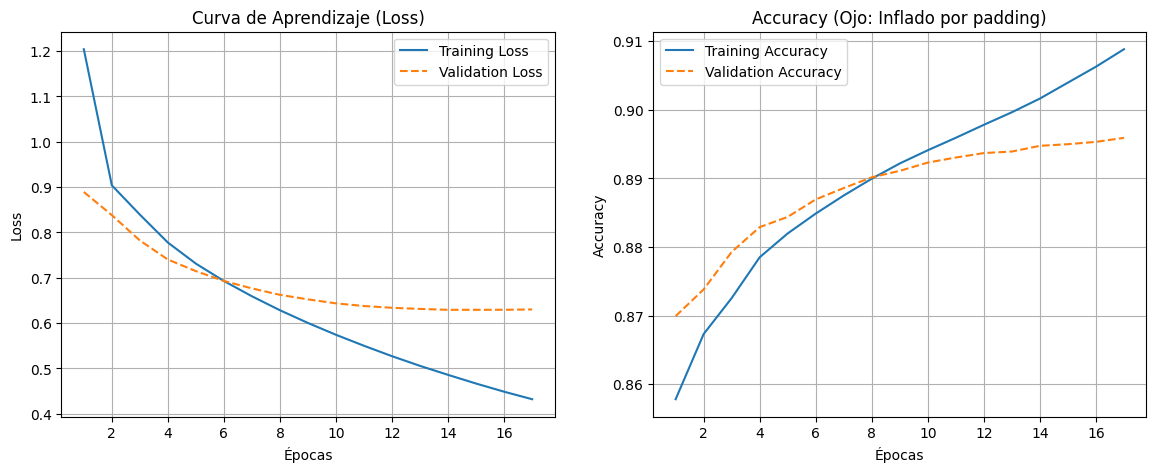

In [27]:
import matplotlib.pyplot as plt
if history is not None:
    # Extraer datos
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    epochs_range = range(1, len(acc) + 1)
    plt.figure(figsize=(14, 5))
    # 1. Gráfico de LOSS (El más importante)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle="--")
    plt.title('Curva de Aprendizaje (Loss)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    # 2. Gráfico de Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle="--")
    plt.title('Accuracy (Ojo: Inflado por padding)')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No hay historial reciente para graficar (se cargaron pesos guardados).")
    print("Si quieres ver gráficos, tienes que borrar el archivo .h5 y re-entrenar.")

### Mejoras implementadas respecto al notebook original (6c)
Para optimizar el entrenamiento con un mayor volumen de datos y mejorar el rendimiento general, realicé los siguientes cambios:
1.  **Optimización de Memoria (Sparse Categorical Crossentropy):**
    *   Reemplacé `categorical_crossentropy` por `sparse_categorical_crossentropy`. Esto evita tener que convertir los targets a *One-Hot Encoding*, lo que generaba un consumo excesivo de RAM. Gracias a esto, pude aumentar el dataset de 6000 a 30000 oraciones sin problemas de memoria.
2.  **Regularización (Dropout):**
    *   Añadí `dropout=0.2` a las capas LSTM para reducir el *overfitting*, ayudando al modelo a generalizar mejor en lugar de memorizar las frases de entrenamiento.
3.  **Callbacks y Entrenamiento:**
    *   Implementé **EarlyStopping** (patience=3) para detener el entrenamiento si no hay mejoras, evitando iteraciones innecesarias.
    *   Agregué **ModelCheckpoint** para guardar y restaurar automáticamente los mejores pesos obtenidos (no los últimos), asegurando un modelo más óptimo.
    *   Aumenté el límite de épocas a 50, dejando que los callbacks controlen la parada.
    *   Incorporé un condicional para que el entrenamiento solo se lleve a cabo si no había un modelo guardado.

### 5 - Inferencia

In [28]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [36]:
# --- INFERENCIA: Definición de modelos para predicción ---
# 1. Modelo Encoder para inferencia
# Toma la entrada y devuelve los estados (h, c)
encoder_model = Model(encoder_inputs, encoder_states)
# 2. Modelo Decoder para inferencia
# Necesitamos entradas para los estados iniciales (que vendrán del encoder o del paso anterior)
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# Entrada para el token actual (un solo paso de tiempo)
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)
# LSTM configurada con los estados iniciales
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
# Modelo final de Decoder para inferencia
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [37]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

**Veamos ahora algunos ejemplos de la traduccion:**

In [39]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
-
Input: Tom was probably joking.
Response: tom estaba muy nervioso


En este caso identifica y traduce vervos. Identifica el nombre Tom. 

In [41]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
-
Input: Tom is Mary's son-in-law.
Response: tom es el mejor de mary


Identifica que hay una relacion o comparacion entre Tom y Mary. Tom es algo de Mary.

In [44]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-
Input: You're safe now.
Response: no estás feliz


En inglés es una oración en afirmativo pero la traduce como una negativa. Ahora al menos identifica el estado y el tiempo verbal. 

In [45]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
-
Input: I haven't ever seen one of these before.
Response: tengo una taza de la oportunidad de la semana


Esta traducción es es mala, pero al menos identificó el have como tengo aunque se use para otra cosa en ingles en este caso.

In [46]:
input_test = "My mother say hi."
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: My mother say hi.
Representacion en vector de tokens de ids [18, 194, 124, 1731]
Padding del vector: [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   18  194  124 1731]]
Input: My mother say hi.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Response: mi hermana le ha pasado


In [47]:
def evaluar_traducciones(cantidad=5):
    """
    Elige 'cantidad' de frases al azar del dataset y muestra
    la frase original en inglés y la traducción generada por el modelo.
    """
    print(f"--- Generando {cantidad} traducciones de prueba ---")
    
    for _ in range(cantidad):
        # 1. Elegir un índice aleatorio
        i = np.random.choice(len(input_sentences))
        
        # 2. Recuperar la secuencia numérica pre-procesada para ese índice
        # Es importante usar [i:i+1] para mantener la dimensión (1, max_len)
        input_seq = encoder_input_sequences[i:i+1]
        
        # 3. Llamar a la función de traducción
        translation = translate_sentence(input_seq)
        
        # 4. Imprimir resultados
        print(f"Entrada (En): {input_sentences[i]}")
        print(f"Salida (Es):  {translation}")
        print("-" * 40)
# Ejecutar la función para probar
evaluar_traducciones(10)

--- Generando 10 traducciones de prueba ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Entrada (En): Tom shook hands with Mary.
Salida (Es):  tom dijo que mary estaba feliz
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Entrada (En): Spring is just around the corner.
Salida (Es):  ella es un buen cantante
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━

### 6 - Conclusión

La verdad es que esperaba mejores resultados para el modelo. 

En algunos casos, las traducciones son muy acertadas, entiende la idea de la frase, identifica la presencia de verbos y los traduce, entiende que habla de personas y conjuga en consecuencia. 

En otros casos, el modelo no logra entender la idea de la frase, por lo que traduce de manera errónea. 

Este modelo fue entrenado en una pc (no mediante Google Colab). Pense que así podia aprovechar mejor los recursos. 

